In [3]:
import torch
import torch.nn as nn
from network import GCNet, DeeperGCN, GCNet3
from train import train_model, plot_results
from data2 import get_sdf_data_loader, get_sdf_data_loader_from_sdf_pixels, plot_mesh
import matplotlib.pyplot as plt
import meshio
import numpy as np

In [4]:
n_objects, batch_size, n_epoch = 100, 1, 200
loss_func = nn.L1Loss()
edge_weight = True
step_size, gamma = 60, 0.5
lr_0 = 0.001

In [ ]:
data_folder = "data2/dataset_3/graph1/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)

In [ ]:
for d in train_data:
    cells = d.face.numpy()
    points = d.x.numpy()
    #points[:, 2] = 0.
    mesh = meshio.Mesh(points=points, cells=[("triangle", cells.T)])
    plt.figure(figsize=(12, 12))
    plot_mesh(mesh)#, vals=pred.numpy()[:, 0], with_colorbar=True, levels=levels, border=border)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
#     plt.subplot(1, 2, 2)
#     plot_mesh(mesh, vals=d.y.numpy()[:, 0], with_colorbar=True, levels=levels, border=border)
#     plt.gca().set_xticks([])
#     plt.gca().set_yticks([])
    plt.show()
    break

In [ ]:
data_folder = "data2/dataset_5/mesh/"
train_data = get_sdf_data_loader_from_sdf_pixels(n_objects, batch_size, filter_params=)

In [ ]:
sdf_pxl

In [ ]:
i= 5
mesh_folder = "data2/dataset_5/mesh/"
sdf_pxl = np.load(mesh_folder + "sdf_pxl%d.npy" % i).astype(float)
pxl_size = 128
assert sdf_pxl.shape[0] == sdf_pxl.shape[1] == pxl_size
sdf_pxl = sdf_pxl.reshape(-1, 1)
xc, yc = np.meshgrid(np.linspace(-1, 1, pxl_size), np.linspace(-1, 1, pxl_size))
xc, yc = xc.reshape(-1, 1), yc.reshape(-1, 1)
img_pxl = (sdf_pxl < 0).astype(float)
x = np.concatenate([xc, yc, img_pxl], axis=-1)
y = sdf_pxl

In [ ]:
np.ravel(np.array([[1],[23]]))

In [ ]:
data_folder = "data2/dataset_3/graph2/"
get_sdf_data_loader_from_sdf_pixels(n_objects, mesh_folder, batch_size, filter_params=[0.222],
                                        reversed_edge_already_included=False

In [ ]:
graph_edges = graph_edges.T

In [ ]:
from torch_geometric.data import Data

In [ ]:
graph_data = Data(x=torch.from_numpy(x).type(torch.float32),
                          y=torch.from_numpy(y).type(torch.float32),
                          edge_index=torch.from_numpy(graph_edges).type(torch.long),
                          edge_attr=torch.from_numpy(graph_edge_weights).type(torch.float32))

preparing sdf data loader


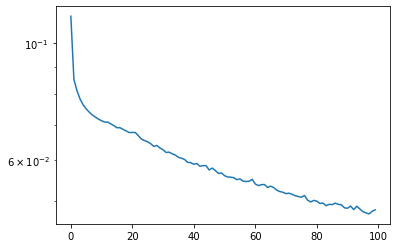

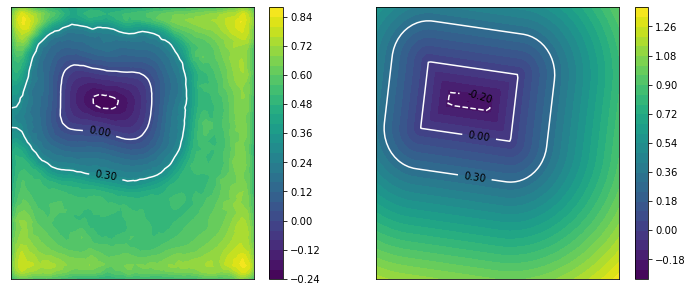

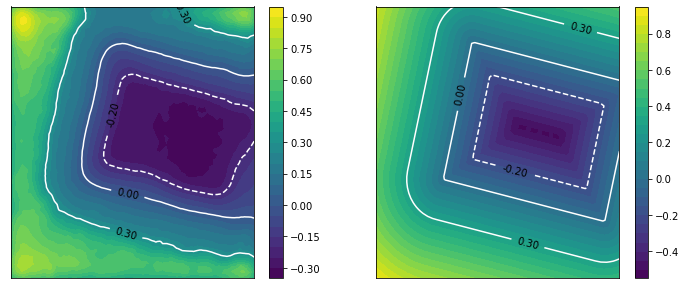

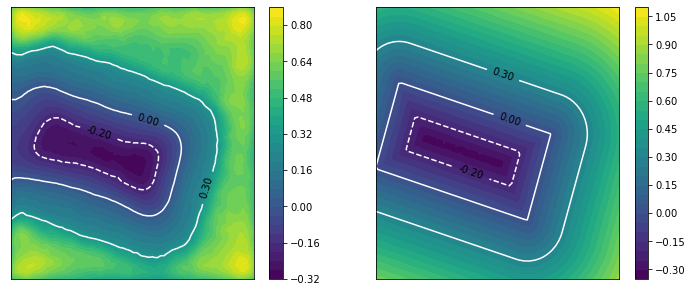

In [12]:
data_folder = "data2/dataset_1/graph5/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
in_channels, out_channels = 3, 1
hidden_channels = [64, 64, 128, 128]
model = GCNet(in_channels, hidden_channels, out_channels)
plot_results(model, train_data, plot_every=5, levels=[-0.2, 0, 0.3])

In [5]:
data_folder = r"data2/dataset_5/mesh/"
train_data = get_sdf_data_loader_from_sdf_pixels(n_objects, data_folder, batch_size)


preparing sdf data loader


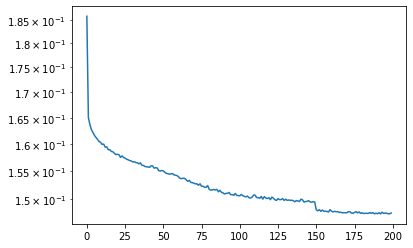

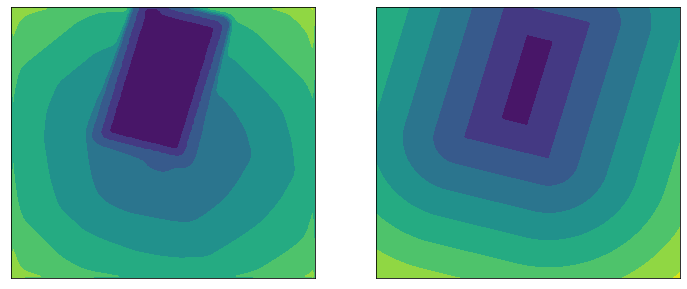

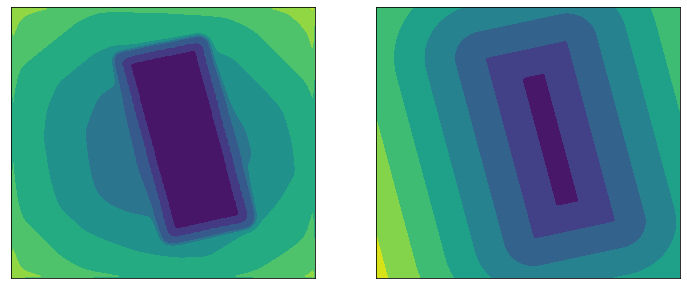

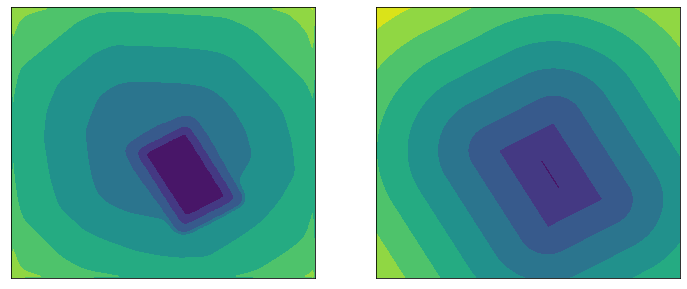

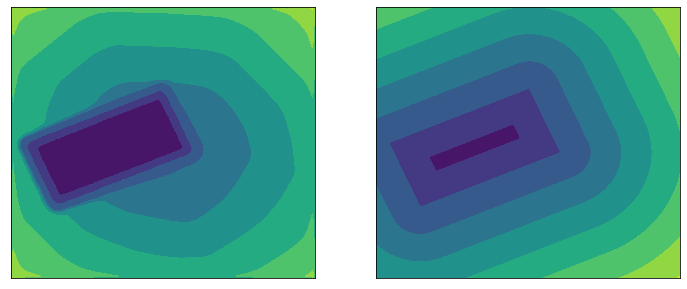

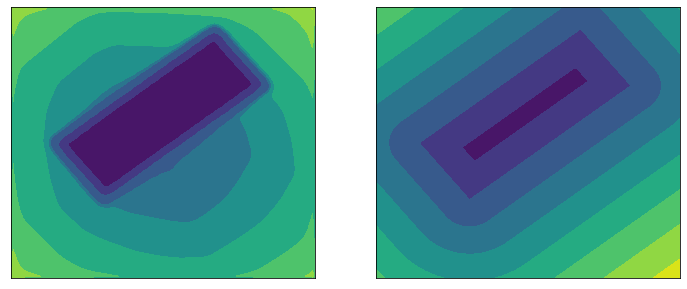

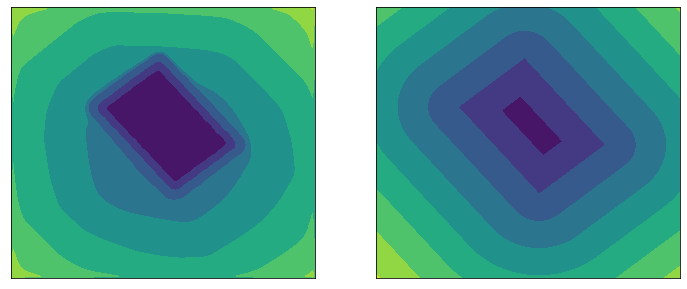

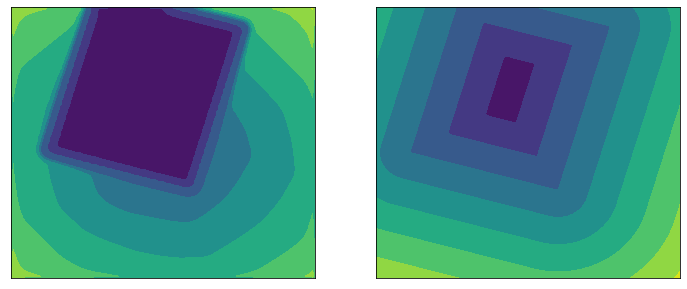

In [9]:
in_channels, out_channels = 3, 1
hidden_channels = [64, 64, 128, 128]
model = GCNet(in_channels, hidden_channels, out_channels)
loss_history = np.load("models/loss.npy")
plt.plot(loss_history)
plt.yscale('log')
device = 'cpu'
model = model.to(device)
model.load_state_dict(torch.load("models/model" + ".pth", map_location=device))
model.eval()
with torch.no_grad():
    for i, d in enumerate(train_data):
        d = d.to(device=device)
        pred = model(d)
        points = d.x.numpy()
        points[:, 2] = 0.
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.contourf(pred.reshape(128, 128))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.subplot(1, 2, 2)
        plt.contourf(d.y.numpy().reshape(128, 128))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.show()
        if i > 5:
            break

In [ ]:
data_folder = "data2/dataset_1/graph4/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)

In [ ]:
step_size, gamma, n_epoch = 150, 0.6, 500
edge_weight = True
radius = 0.1
batch_size = 1
data_folder = "data2/dataset_5/graph4/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma, radius=radius)
plot_results(model, train_data, plot_every=5, border=0.1, levels=[-0.2, -0.1, 0, 0.1, 0.2, 0.4])

In [ ]:
edge_weight = True
batch_size = 1
hidden_channels = [128, 128, 128, 128]
data_folder = "data2/dataset_5/graph7/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
# model = GCNet(in_channels, hidden_channels, out_channels)
model = GCNet3(in_channels, hidden_channels, out_channels)
#model = DeeperGCN(3, 128, 1, 4, 1)
#train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma, radius=radius)
plot_results(model, train_data, plot_every=10, border=0.1)#, levels=[-0.2, -0.1, 0, 0.1, 0.2, 0.4])

In [ ]:
plot_results(model, train_data, plot_every=10, border=0.1, levels=[-0.2, -0.1, 0, 0.1, 0.2, 0.4])

In [ ]:
step_size, gamma, n_epoch = 150, 0.6, 500
edge_weight = False
radius = 0.1
batch_size = 5
data_folder = "data2/dataset_1/graph11/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma, radius=radius)
plot_results(model, train_data, plot_every=5)

In [ ]:
step_size, gamma, n_epoch = 150, 0.5, 200
radius = 0.1
batch_size = 5
data_folder = "data2/dataset_1/graph5/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma, radius=radius)
plot_results(model, train_data, plot_every=5)

In [ ]:
step_size, gamma, n_epoch = 150, 0.5, 600
data_folder = "data2/dataset_1/graph6/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)

In [ ]:
data_folder = "data2/dataset_1/graph7/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)

In [ ]:
data_folder = "data2/dataset_1/graph8/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)

In [ ]:
data_folder = "data2/dataset_1/graph9/"
train_data = get_sdf_data_loader(n_objects, data_folder, batch_size, edge_weight=edge_weight)
model = GCNet(in_channels, hidden_channels, out_channels)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)
plot_results(model, train_data, plot_every=5)

In [ ]:
from torch_geometric.data import Data, DataLoader

In [ ]:
train_data = get_sdf_data_loader2(n_objects, data_folder, batch_size, edge_weight=False)


In [ ]:
def get_sdf_data_loader2(n_objects, data_folder, batch_size, reversed_edge_already_included=False, edge_weight=False):
    graph_data_list = []
    print("preparing sdf data loader")
    for i in range(n_objects):
        graph_nodes = np.load(data_folder + "graph_nodes%d.npy" % i).astype(float)
        x = graph_nodes.copy()
        x[:, 2] = (x[:, 2] < 0).astype(float)
        x[:, 5] = (x[:, 5] < 0).astype(float)
        y = graph_nodes.copy()[:, [2, 5]]
        graph_cells = np.load(data_folder + "graph_cells%d.npy" % i).astype(int)
        graph_cells = graph_cells.T
        graph_edges = np.load(data_folder + "graph_edges%d.npy" % i).astype(int)
        if not reversed_edge_already_included:
            graph_edges = add_reversed_edges(graph_edges)
        graph_edges = graph_edges.T
        n_edges = graph_edges.shape[1]
        if edge_weight:
            graph_edge_weights = np.load(data_folder + "graph_weights%d.npy" %i).astype(float)
            if graph_edge_weights.shape[0] == n_edges:
                pass
            elif graph_edge_weights.shape[0] == n_edges // 2:
                graph_edge_weights = np.concatenate([graph_edge_weights, graph_edge_weights])
            else:
                raise("edge weight size is wrong.")
            #graph_edge_weights = graph_edge_weights.reshape(-1, 1)
        else:
            graph_edge_weights = np.ones(n_edges)

        graph_data = Data(x=torch.from_numpy(x).type(torch.float32),
                          y=torch.from_numpy(y).type(torch.float32),
                          edge_index=torch.from_numpy(graph_edges).type(torch.long),
                          edge_attr=torch.from_numpy(graph_edge_weights).type(torch.float32),
                          face=torch.from_numpy(graph_cells).type(torch.long))
        graph_data_list.append(graph_data)
    train_data = DataLoader(graph_data_list, batch_size=batch_size)
    return train_data

In [ ]:
i = 1
graph_nodes1 = np.load("data2/dataset_1/graph1/graph_nodes%d.npy" % i).astype(float)
graph_nodes2 = np.load("data2/dataset_1/graph10/graph_nodes%d.npy" % i).astype(float)

In [ ]:
graph_nodes1.shape, graph_nodes2.shape

In [ ]:
plt.plot(graph_nodes1[:, 0], graph_nodes1[:, 1], 'r.')

In [ ]:
data_folder = "data2/dataset_1/graph10/"
train_data = get_sdf_data_loader2(n_objects, data_folder, batch_size, edge_weight=False)
model = GCNet(6, hidden_channels, 2)
train_model(model, train_data, lr_0=lr_0, n_epoch=n_epoch, loss_func=loss_func, step_size=step_size, gamma=gamma)

In [ ]:
def plot_results2(model, data):
    
    loss_history = np.load("models/loss.npy")
    plt.plot(loss_history)
    plt.yscale('log')

    device = 'cpu'
    model = model.to(device)
    model.load_state_dict(torch.load("models/model" + ".pth", map_location=device))
    model.eval()
    with torch.no_grad():
        for i, d in enumerate(data):
            d = d.to(device=device)
            pred = model(d)
            cells = d.face.numpy()
            points = d.x.numpy()[:, :3]
            points[:, 2] = 0.
            mesh = meshio.Mesh(points=points, cells=[("triangle", cells.T)])
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plot_mesh(mesh, vals=pred.numpy()[:, 0])
            plt.colorbar()
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.subplot(1, 2, 2)
            plot_mesh(mesh, vals=d.y.numpy()[:, 0])
            plt.colorbar()
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.show()
            break

In [ ]:
plot_results2(model, train_data)

In [ ]:
def mesh_to_pixel_training(model, train_data, labels):
    print("training begins")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_0, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    running_loss_list = []
    for epoch in range(1, n_epoch):
        running_loss = 0
        for d, l in zip(train_data, labels):
            d = d.to(device)
            if with_eikonal_loss:
                d.x.requires_grad = True
                #Todo: make sure d.x does not participate in optimization.
            model.train()
            optimizer.zero_grad()
            pred = model(d)
            target = l
            loss = loss_func(pred, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        if epoch % print_every == 0:
            print("epoch=%d, loss=%0.5e, lr=%0.5e" % (epoch, running_loss / len(train_data),
                                                      optimizer.param_groups[0]['lr']))
        running_loss_list.append(running_loss / len(train_data))

    torch.save(model.state_dict(), "models/model" + ".pth")
    np.save("models/loss.npy", running_loss_list)
    

In [ ]:
from data2 import *
from tqdm import tqdm

geometries = ["Rectangle"]
n_objects = 100

root_folder = "data2/dataset_4/"
mesh_folder = root_folder + "mesh/"
mesh_coarse_size, mesh_fine_size, skip_every, refined = 0.1, 0.025, 2, True
mesh_data = MeshData(geometries, mesh_coarse_size, mesh_fine_size, refined, skip_every)



In [ ]:
mesh_data.write_mesh_features_to_file(mesh_folder)
for i in range(n_objects):
    plot = True if i % 10 == 0 else False
    mesh_data.generate_sdf_mesh(mesh_folder, name=str(i), plot=plot, save_sdf_pxl=True)

In [ ]:
graph_folder = root_folder + "graph1/"
graph_data = GraphData(graph_node="vertex", graph_edge="edge", edge_length=1, edge_weight="length")
graph_data.generate_graph_data(n_objects, mesh_folder, graph_folder=graph_folder)
graph_data.write_graph_features_to_file(graph_folder)

In [ ]:
from torch.utils.data import DataLoader as DL

In [ ]:
labels = []
for i in range(n_objects):
    sdf_pxl_file = mesh_folder + "sdf_pxl" + str(i) + ".npy"
    sdf_pxl = np.load(sdf_pxl_file)
    labels.append(sdf_pxl)
labels = DL(labels, batch_size=1)

In [ ]:
for i in labels:
    print(i)
    print(i.shape)
    break

In [ ]:
class GCNet_mixed(torch.nn.Module):
    def __init__(self, in_channels, hidden_gcnn_channels, hidden_cnn_channels, out_channels, act=F.relu):
        super(GCNet, self).__init__()
        self.in_channels = in_channels
        self.hidden_gcnn_channels = hidden_gcnn_channels
        self.hidden_cnn_channel = hidden_cnn_channels
        self.out_channels = out_channels
        self.act = act

        self.gconvs = torch.nn.ModuleList()
        self.gconvs.append(GCNConv(in_channels, hidden_gcnn_channels[0], improved=True))
        for i in range(len(hidden_gcnn_channels) - 1):
            self.gconvs.append(GCNConv(hidden_gcnn_channels[i], hidden_gcnn_channels[i+1], improved=True))
        self.gconvs.append(GCNConv(hidden_gcnn_channels[-1], hidden_cnn_channels, improved=True))
        
        self.reset_parameters()

        self.convs = torch.nn.ModuleList()
        for i in range(len(hidden_cnn_channels) - 1):
            self.convs.append(Conv(hidden_cnn_channels[i], hidden_cnn_channels[i+1]))
        self.convs.append(Conv(hidden_cnn_channels[-1], out_channels))
        
    def reset_parameters(self):
        for gconv in self.gconvs:
            gconv.reset_parameters()

    def forward(self, data):
        """"""
        x = data.x
        edge_index = data.edge_index
        #edge_weight = x.new_ones(edge_index.size(1))
        edge_weight = data.edge_attr

        for i in range(len(self.convs) - 1):
            #edge_index, edge_weight = self.augment_adj(edge_index, edge_weight, x.size(0))
            x = self.convs[i](x, edge_index, edge_weight)
            x = self.act(x)

        #edge_index, edge_weight = self.augment_adj(edge_index, edge_weight, x.size(0))
        x = self.convs[-1](x, edge_index, edge_weight)

        return x

    def augment_adj(self, edge_index, edge_weight, num_nodes):
        edge_index, edge_weight = add_self_loops(edge_index, edge_weight,
                                                 num_nodes=num_nodes)
        edge_index, edge_weight = sort_edge_index(edge_index, edge_weight,
                                                  num_nodes)
        edge_index, edge_weight = spspmm(edge_index, edge_weight, edge_index,
                                         edge_weight, num_nodes, num_nodes,
                                         num_nodes)
        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        return edge_index, edge_weight

    def __repr__(self):
        return '{}({}, {}, {}, depth={}, pool_ratios={})'.format(
            self.__class__.__name__, self.in_channels, self.hidden_channels,
            self.out_channels, self.depth, self.pool_ratios)
